# Changes in Airbnb's geographic distribution between 2019 and 2022

## CASA0013: Foundations of Spatial Data Science

### Student Ids:22126584, 21146155, 22107674

import packages

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import contextily
import geopandas
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
from matplotlib.colors import ListedColormap

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
from pysal.lib import weights
from pysal.explore import esda
import mapclassify

/opt/conda/lib/python3.10/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


import data sets

In [3]:
# data of Airbnb listings in 2019 and 2022

airbnb_2019=pd.read_csv('https://raw.githubusercontent.com/JinShangqi/fsds_groupwork/main/London-2019-11-listings.csv')
airbnb_2022=pd.read_csv('https://raw.githubusercontent.com/JinShangqi/fsds_groupwork/main/2022listings.csv')

In [4]:
# print to check
print(f"Data frame is {airbnb_2019.shape[0]:,} x {airbnb_2019.shape[1]}")
print(f"Data frame is {airbnb_2022.shape[0]:,} x {airbnb_2022.shape[1]}")

Data frame is 84,913 x 18
Data frame is 69,351 x 18


In [5]:
airbnb_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84913 entries, 0 to 84912
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              84913 non-null  object
 1   name                            84913 non-null  object
 2   host_id                         84913 non-null  object
 3   host_name                       84913 non-null  object
 4   neighbourhood_group             84913 non-null  object
 5   neighbourhood                   84913 non-null  object
 6   latitude                        84913 non-null  object
 7   longitude                       84913 non-null  object
 8   room_type                       84913 non-null  object
 9   price                           84913 non-null  object
 10  minimum_nights                  84913 non-null  object
 11  number_of_reviews               84913 non-null  object
 12  last_review                     84913 non-null

In [6]:
airbnb_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              69351 non-null  int64  
 1   name                            69330 non-null  object 
 2   host_id                         69351 non-null  int64  
 3   host_name                       69346 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   69351 non-null  object 
 6   latitude                        69351 non-null  float64
 7   longitude                       69351 non-null  float64
 8   room_type                       69351 non-null  object 
 9   price                           69351 non-null  int64  
 10  minimum_nights                  69351 non-null  int64  
 11  number_of_reviews               69351 non-null  int64  
 12  last_review                     

In [7]:
# import spatial data

## preparation

import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [9]:
# lsoa data
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

lsoas = gpd.read_file( cache_data(spath+'LSOAs.gpkg?raw=true', ddir) )

print('Done.')

data/geo/LSOAs.gpkg not found, downloading!
Done downloading...
Done.


In [10]:
# use head to check the polygon file
lsoas.head()

,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,geometry
0,1,E01000001,City of London 001A,City of London 001A,133320.768872,2291.846072,"MULTIPOLYGON (((532106.894 182011.476, 532164...."
1,2,E01000002,City of London 001B,City of London 001B,226191.272990,2433.960112,"MULTIPOLYGON (((532748.624 181787.125, 532673...."
2,3,E01000003,City of London 001C,City of London 001C,57302.966538,1142.359799,"MULTIPOLYGON (((532136.950 182198.368, 532160...."
3,4,E01000005,City of London 001E,City of London 001E,190738.760504,2167.868343,"MULTIPOLYGON (((533809.765 180767.968, 533650...."
4,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,144195.846857,1935.510354,"MULTIPOLYGON (((545123.925 184315.102, 545273...."


In [11]:
lsoas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7166 entries, 0 to 7165
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    7166 non-null   int64   
 1   lsoa11cd    7166 non-null   object  
 2   lsoa11nm    7166 non-null   object  
 3   lsoa11nmw   7166 non-null   object  
 4   st_areasha  7166 non-null   float64 
 5   st_lengths  7166 non-null   float64 
 6   geometry    7166 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 392.0+ KB


In [12]:
# check crs
print(lsoas.crs)

epsg:27700


In [14]:
# borough data
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )

Found data/geo/Boroughs.gpkg locally!


In [15]:
# use head to check the csv file
boros.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
1,Croydon,E09000008,8649.441,0.000,F,"MULTIPOLYGON (((535009.200 159504.700, 535005...."
2,Bromley,E09000006,15013.487,0.000,F,"MULTIPOLYGON (((540373.600 157530.400, 540361...."
3,Hounslow,E09000018,5658.541,60.755,F,"MULTIPOLYGON (((521975.800 178100.000, 521967...."
4,Ealing,E09000009,5554.428,0.000,F,"MULTIPOLYGON (((510253.500 182881.600, 510249...."


In [16]:
# check crs
print(boros.crs)

epsg:27700


Data wrangling

In [17]:
## clean 2019 airbnb data
# transfrom 2019 data type
cols = ['latitude', 'longitude']
airbnb_2019[cols] = airbnb_2019[cols].apply(pd.to_numeric, errors='coerce', axis=1)

airbnb_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84913 entries, 0 to 84912
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              84913 non-null  object 
 1   name                            84913 non-null  object 
 2   host_id                         84913 non-null  object 
 3   host_name                       84913 non-null  object 
 4   neighbourhood_group             84913 non-null  object 
 5   neighbourhood                   84913 non-null  object 
 6   latitude                        84911 non-null  float64
 7   longitude                       84911 non-null  float64
 8   room_type                       84913 non-null  object 
 9   price                           84913 non-null  object 
 10  minimum_nights                  84913 non-null  object 
 11  number_of_reviews               84913 non-null  object 
 12  last_review                     

In [18]:
# check the number of na values
airbnb_2019.isna().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          2
longitude                         2
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
room_class                        0
last_review_timestamp             0
dtype: int64

In [19]:
# remove na values
airbnb_2019.dropna(axis=0, how='any', inplace=True)

In [20]:
# convert datatype of 'price' to integer
airbnb_2019['price'] = np.int64(airbnb_2019['price'])

In [21]:
# use info to check 2019 airbnb data set's datatype
airbnb_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84911 entries, 0 to 84910
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              84911 non-null  object 
 1   name                            84911 non-null  object 
 2   host_id                         84911 non-null  object 
 3   host_name                       84911 non-null  object 
 4   neighbourhood_group             84911 non-null  object 
 5   neighbourhood                   84911 non-null  object 
 6   latitude                        84911 non-null  float64
 7   longitude                       84911 non-null  float64
 8   room_type                       84911 non-null  object 
 9   price                           84911 non-null  int64  
 10  minimum_nights                  84911 non-null  object 
 11  number_of_reviews               84911 non-null  object 
 12  last_review                     

In [22]:
# Transform data from csv to points

points_2022= gpd.GeoDataFrame(airbnb_2022, 
      geometry=gpd.points_from_xy(airbnb_2022.longitude, airbnb_2022.latitude, crs='epsg:4326'))

points_2019= gpd.GeoDataFrame(airbnb_2019, 
      geometry=gpd.points_from_xy(airbnb_2019.longitude, airbnb_2019.latitude, crs='epsg:4326'))

In [23]:
# unify the crs of airbnb‘s points with the polygons'.
points_2019=points_2019.to_crs('epsg:27700')
points_2022=points_2022.to_crs('epsg:27700')

In [24]:
# join the points data with polygons
## join with lsoa ploygon
lsoa2019= gpd.sjoin(points_2019, lsoas,predicate='within').drop(
                        columns=['latitude', 'longitude','index_right']
                )

lsoa2022 = gpd.sjoin(points_2022, lsoas,predicate='within').drop(
                        columns=['latitude', 'longitude','index_right']
                )

## join with boro polygon
boro2019 = gpd.sjoin(points_2019, boros,predicate='within').drop(
                        columns=['latitude', 'longitude','index_right']
                )
boro2022 = gpd.sjoin(points_2022, boros,predicate='within').drop(
                        columns=['latitude', 'longitude','index_right']
                )

In [25]:
# add column 'Local authority names' and filter listings in London boroughs

lsoas['Local authority name'] = lsoas['lsoa11nmw'].apply(lambda s: s.split(' ')[0])

lsoa=lsoas.loc[lsoas['Local authority name'].isin(['Barnet','Bexley','Brent','Bromley',
                                                                            'Camden','Croydon','Ealing','Enfield',
                                                                            'Greenwich','Hackney','Hammersmith',
                                                                            'Haringey','Harrow','Havering','Hillingdon',
                                                                            'Hounslow','Islington','Kensington',
                                                                            'Kingston','Lambeth','Lewisham','Merton',
                                                                            'Newham','Redbridge','Richmond','Southwark',
                                                                            'Sutton','Tower','Waltham','Wandsworth','Westminster',
                                                                            'City'])]

In [26]:
lsoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4725 entries, 0 to 7165
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   objectid              4725 non-null   int64   
 1   lsoa11cd              4725 non-null   object  
 2   lsoa11nm              4725 non-null   object  
 3   lsoa11nmw             4725 non-null   object  
 4   st_areasha            4725 non-null   float64 
 5   st_lengths            4725 non-null   float64 
 6   geometry              4725 non-null   geometry
 7   Local authority name  4725 non-null   object  
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 332.2+ KB


descriptive statistics

In [27]:
lsoa2019.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,...,availability_365,room_class,last_review_timestamp,geometry,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths
0,20009078,"""A bit on the side!""",142030125,Barry,,Bromley,Entire home/apt,147,3,3,...,314,Entire home/apt,5/29/2019 0:00:00,POINT (543349.053 157077.664),734,E01000748,Bromley 042C,Bromley 042C,9.882356e+06,19255.091032
1,5767949,"The Barn at Bombers , Westerham Kent",29924426,Roy,,Bromley,Entire home/apt,130,7,1,...,340,Entire home/apt,9/4/2018 0:00:00,POINT (544949.411 157405.378),734,E01000748,Bromley 042C,Bromley 042C,9.882356e+06,19255.091032
7,17024850,The Secret Cottage - Westerham,57519286,Amanda,,Bromley,Entire home/apt,120,2,28,...,319,Entire home/apt,10/23/2019 0:00:00,POINT (543225.571 157576.101),734,E01000748,Bromley 042C,Bromley 042C,9.882356e+06,19255.091032
9,36862755,The Hidden Cottage,57519286,Amanda,,Bromley,Entire home/apt,150,2,0,...,259,Entire home/apt,,POINT (543378.913 157605.988),734,E01000748,Bromley 042C,Bromley 042C,9.882356e+06,19255.091032
10,24876726,Little Buckhurst,170007735,Miranda,,Bromley,Private room,100,1,67,...,164,Private room,10/28/2019 0:00:00,POINT (543155.429 157714.358),734,E01000748,Bromley 042C,Bromley 042C,9.882356e+06,19255.091032


In [28]:
#to sum the count of airbnb by borough using groupby
#2019
bcount2019 = boro2019.groupby(['GSS_CODE']).id.agg(Count="count")
bcount2019.head()

,Count
GSS_CODE,
E09000001,464
E09000002,372
E09000003,1651
E09000004,269
E09000005,2555


In [29]:
#2022
bcount2022 = boro2022.groupby(['GSS_CODE']).id.agg(Count="count")
bcount2022.head()

,Count
GSS_CODE,
E09000001,420
E09000002,424
E09000003,1574
E09000004,332
E09000005,2068


In [30]:
#add spatial infomation on the data frame
count=boros.merge(bcount2022,on='GSS_CODE', how='left')

In [31]:
#add 2022 airbnb infomation on the data frame
count=count.merge(bcount2019,on='GSS_CODE', how='left')
count.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,Count_x,Count_y
0,Kingston upon Thames,E09000021,3726.117,0.000,F,"MULTIPOLYGON (((516401.600 160201.800, 516407....",566,551
1,Croydon,E09000008,8649.441,0.000,F,"MULTIPOLYGON (((535009.200 159504.700, 535005....",1041,1098
2,Bromley,E09000006,15013.487,0.000,F,"MULTIPOLYGON (((540373.600 157530.400, 540361....",574,678
3,Hounslow,E09000018,5658.541,60.755,F,"MULTIPOLYGON (((521975.800 178100.000, 521967....",1004,1028
4,Ealing,E09000009,5554.428,0.000,F,"MULTIPOLYGON (((510253.500 182881.600, 510249....",1553,1745


In [32]:
#rename the column name for better use
count=count.rename(columns = {'Count_x':'count2022','Count_y':'count2019'})

In [33]:
#count the difference rate in those three years
count.loc[:,['count_p']]=(count['count2022']-count['count2019'])/count['count2019']*100
count.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,count2022,count2019,count_p
0,Kingston upon Thames,E09000021,3726.117,0.000,F,"MULTIPOLYGON (((516401.600 160201.800, 516407....",566,551,2.722323
1,Croydon,E09000008,8649.441,0.000,F,"MULTIPOLYGON (((535009.200 159504.700, 535005....",1041,1098,-5.191257
2,Bromley,E09000006,15013.487,0.000,F,"MULTIPOLYGON (((540373.600 157530.400, 540361....",574,678,-15.339233
3,Hounslow,E09000018,5658.541,60.755,F,"MULTIPOLYGON (((521975.800 178100.000, 521967....",1004,1028,-2.334630
4,Ealing,E09000009,5554.428,0.000,F,"MULTIPOLYGON (((510253.500 182881.600, 510249....",1553,1745,-11.002865


In [34]:
#project data frame
count= gpd.GeoDataFrame(count, 
      geometry=count['geometry'], crs='epsg:27700')

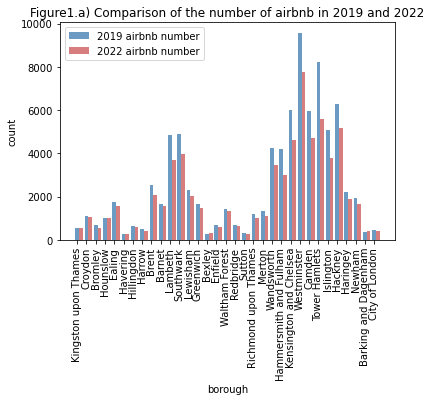

In [35]:
#plot bar chart with airbnb counts in 2019 and 2022
x_data = count['NAME']
y_data = count['count2019']
y_data2 = count['count2022']
#set bar width
bar_width=0.4

#2019 data
plt.bar(x=range(len(x_data)), height=y_data, label='2019 airbnb number',
color='steelblue', alpha=0.8, width=bar_width)
#2022 data
plt.bar(x=np.arange(len(x_data))+bar_width, height=y_data2,
        label='2022 airbnb number', color='indianred', alpha=0.8, width=bar_width)

#horizontal axis
plt.xticks(count.index,count['NAME'],fontsize=10, rotation=90)

plt.title("Figure1.a) Comparison of the number of airbnb in 2019 and 2022")

plt.xlabel("borough")
plt.ylabel("count")

plt.legend()
plt.savefig('Fig1a.png')#plot show and save

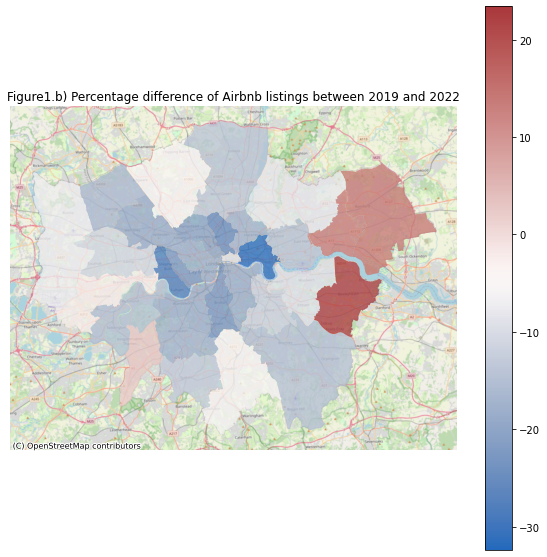

In [36]:
#plot the difference rate

f, ax = plt.subplots(1, figsize=(10,10))
count.plot(                 
    column='count_p', 
    cmap='vlag', 
    edgecolor='none', 
    ax=ax,
    alpha=0.75,
    legend=True)

ax.set_axis_off()
ax.set_title("Figure1.b) Percentage difference of Airbnb listings between 2019 and 2022")
contextily.add_basemap(
    ax,
    crs=count.crs,
    source=contextily.providers.OpenStreetMap.Mapnik)
plt.savefig('Fig1b.png')#plot show and save

LISA

In [37]:
#to sum the count of airbnb by lsoa using groupby
#2019
count2019 = lsoa2019.groupby(['lsoa11cd']).id.agg(Count2019="count")
count2019.head()

,Count2019
lsoa11cd,
E01000001,17
E01000002,10
E01000003,7
E01000005,74
E01000006,5


In [38]:
#2022
count2022 = lsoa2022.groupby(['lsoa11cd']).id.agg(Count2022="count")
count2022.head()

,Count2022
lsoa11cd,
E01000001,14
E01000002,9
E01000003,19
E01000005,118
E01000006,4


In [39]:
# add the number of Airbnb listings in 2019 and 2022 to lsoa data
lsoa1 = lsoa.merge(count2022,on='lsoa11cd', how='left')
lsoa2 = lsoa1.merge(count2019,on='lsoa11cd', how='left')

In [40]:
# calculate difference and add column
lsoa2['airbnb_difference']=lsoa2['Count2022']-lsoa2['Count2019']

In [41]:
lsoa2.head()

,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,geometry,Local authority name,Count2022,Count2019,airbnb_difference
0,1,E01000001,City of London 001A,City of London 001A,133320.768872,2291.846072,"MULTIPOLYGON (((532106.894 182011.476, 532164....",City,14.0,17.0,-3.0
1,2,E01000002,City of London 001B,City of London 001B,226191.272990,2433.960112,"MULTIPOLYGON (((532748.624 181787.125, 532673....",City,9.0,10.0,-1.0
2,3,E01000003,City of London 001C,City of London 001C,57302.966538,1142.359799,"MULTIPOLYGON (((532136.950 182198.368, 532160....",City,19.0,7.0,12.0
3,4,E01000005,City of London 001E,City of London 001E,190738.760504,2167.868343,"MULTIPOLYGON (((533809.765 180767.968, 533650....",City,118.0,74.0,44.0
4,112,E01000115,Barnet 009A,Barnet 009A,279821.769491,3269.296358,"MULTIPOLYGON (((528926.389 194720.038, 529145....",Barnet,3.0,1.0,2.0


In [42]:
df=lsoa2

In [43]:
# create spatial weights matrix for autocorrelation 
w = weights.Queen.from_dataframe(df, idVariable='lsoa11cd')

In [44]:
# examine islands
w.islands

[]

In [45]:
# row-standardize the queen matrix
w.transform = 'R'

In [46]:
# standardise the variables
df['airbnb_difference_std'] = (df['airbnb_difference'] - df['airbnb_difference'].mean()) / df['airbnb_difference'].std()

In [47]:
# calculate spatial lag `airbnb_percentage_difference`
df['w_airbnb_difference_std'] = weights.lag_spatial(w, df['airbnb_difference_std'])

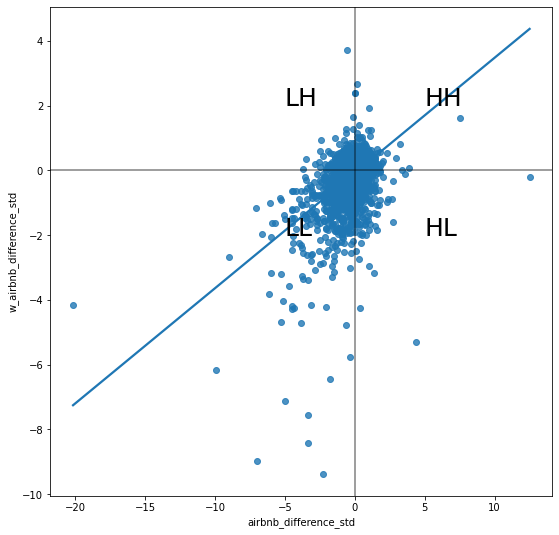

In [49]:
# Plot distribution of values
f, ax = plt.subplots(1, figsize=(9, 9))

sns.regplot(x='airbnb_difference_std', y='w_airbnb_difference_std', data=df, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(5, 2, "HH", fontsize=25)
plt.text(5, -2, "HL", fontsize=25)
plt.text(-5, 2, "LH", fontsize=25)
plt.text(-5, -2, "LL", fontsize=25)

plt.show()

In [50]:
# compute Local Indicators of Spatial Association - LISA
lisa = esda.Moran_Local(df['airbnb_difference'], w)

In [51]:
# examine whether the observations are significant
df['significant'] = lisa.p_sim < 0.05

In [52]:
df['significant'].head()

0    True
1    True
2    True
3    True
4    True
Name: significant, dtype: bool

In [53]:
# examine first 5 observations
lisa.p_sim[:5]

array([0.001, 0.001, 0.001, 0.001, 0.001])

In [54]:
# assign obeservations to 4 quadrants
def myfunc(airbnb_difference_std, w_airbnb_difference_std):
    if airbnb_difference_std < 0 and w_airbnb_difference_std < 0:
        quadrant='LL'
    elif airbnb_difference_std < 0 and w_airbnb_difference_std > 0:
        quadrant='LH'
    elif airbnb_difference_std > 0 and w_airbnb_difference_std < 0:
        quadrant='HL'
    elif airbnb_difference_std > 0 and w_airbnb_difference_std > 0:
        quadrant='HH'
    else:
        quadrant='Insignificant'
    return quadrant

df['quadrant'] = df.apply(lambda x: myfunc(x['airbnb_difference_std'], x['w_airbnb_difference_std']), axis=1)

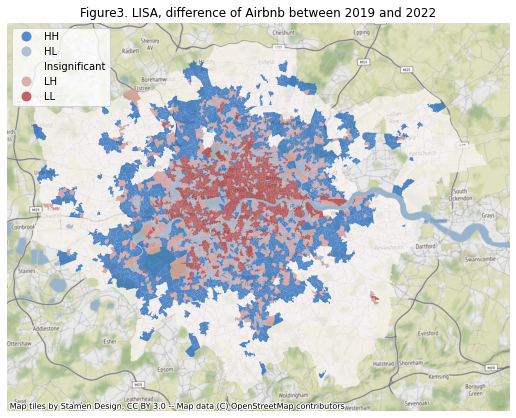

In [55]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.plot(column="quadrant",
    cmap="vlag",
    edgecolor="white",
    alpha=0.75,
    linewidth=0.0,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,)

ax.set_axis_off()
ax.set_title("Figure3. LISA, difference of Airbnb between 2019 and 2022")
contextily.add_basemap(
    ax,
    crs=df.crs,
    # source=contextily.providers.OpenStreetMap.Mapnik,
)

plt.savefig('Fig3.png')#plot show and save

Kernel Density Estimation

In [63]:
points_2019.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 84911 entries, 0 to 84910
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              84911 non-null  object  
 1   name                            84911 non-null  object  
 2   host_id                         84911 non-null  object  
 3   host_name                       84911 non-null  object  
 4   neighbourhood_group             84911 non-null  object  
 5   neighbourhood                   84911 non-null  object  
 6   latitude                        84911 non-null  float64 
 7   longitude                       84911 non-null  float64 
 8   room_type                       84911 non-null  object  
 9   price                           84911 non-null  int64   
 10  minimum_nights                  84911 non-null  object  
 11  number_of_reviews               84911 non-null  object  
 12  last_revie

In [64]:
# select columns
kde_2019=points_2019.iloc[:,6:8]
kde_2022=points_2022.iloc[:,6:8]

In [65]:
# transform data from csv to points

kde_2022= gpd.GeoDataFrame(kde_2022, 
      geometry=gpd.points_from_xy(kde_2022.longitude, kde_2022.latitude, crs='epsg:27700'))

kde_2019= gpd.GeoDataFrame(kde_2019, 
      geometry=gpd.points_from_xy(kde_2019.longitude, kde_2019.latitude, crs='epsg:27700'))

CPU times: total: 48.2 s
Wall time: 47 s


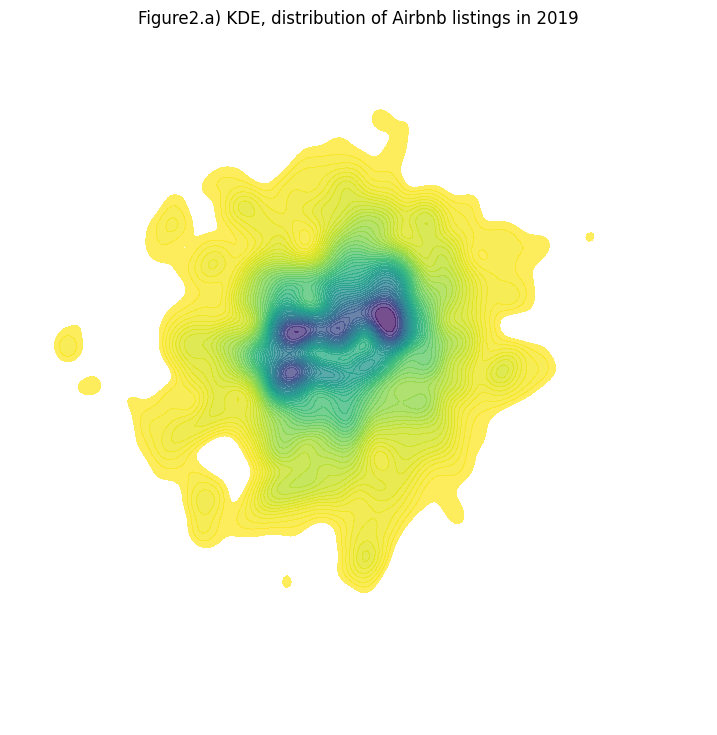

In [68]:
%%time

# Plot KDE of 2019 Aribnb listings
f, ax = plt.subplots(1, figsize=(9, 9))


sns.kdeplot(
    x = kde_2019["longitude"],
    y = kde_2019["latitude"],
    n_levels=50,
    shade=True,
    alpha=0.75,
    cmap="viridis_r",
    ax=ax)

ax.set_axis_off()
ax.set_title("Figure2.a) KDE, distribution of Airbnb listings in 2019")


plt.savefig('Fig2a.png')#plot show and save

CPU times: total: 38.5 s
Wall time: 37 s


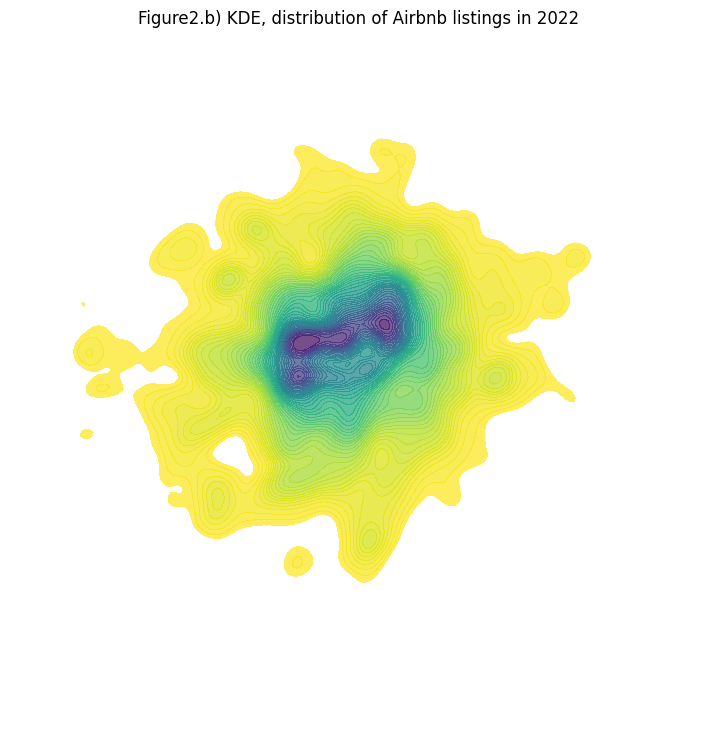

In [70]:
%%time

# Plot KDE of 2022 Aribnb listings
f, ax = plt.subplots(1, figsize=(9, 9))

sns.kdeplot(
    x = kde_2022["longitude"],
    y = kde_2022["latitude"],
    n_levels=50,
    shade=True,
    alpha=0.75,
    cmap="viridis_r",
    ax=ax)

ax.set_axis_off()
ax.set_title("Figure2.b) KDE, distribution of Airbnb listings in 2022")


plt.savefig('Fig3b.png')#plot show and save